In [1]:
#!pip install hmmlearn

%matplotlib inline
from hmmlearn import hmm
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
import scipy.stats as stats
import statsmodels.api as sm
#import gdown

In [2]:
ticker = "^GSPC"  #S&P 500 index symbol
daily = yf.download(ticker, start="1950-03-01", end="2016-11-30", interval="1d")

daily = daily[daily.columns[0:4]]
daily

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
1950-03-01,17.240000,17.240000,17.240000,17.240000
1950-03-02,17.230000,17.230000,17.230000,17.230000
1950-03-03,17.290001,17.290001,17.290001,17.290001
1950-03-06,17.320000,17.320000,17.320000,17.320000
1950-03-07,17.200001,17.200001,17.200001,17.200001
...,...,...,...,...
2016-11-22,2201.560059,2204.800049,2194.510010,2202.939941
2016-11-23,2198.550049,2204.719971,2194.510010,2204.719971
2016-11-25,2206.270020,2213.350098,2206.270020,2213.350098


In [3]:
# Resample the data to monthly frequency
full = daily.resample('MS').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})

# Reset the index to have 'Date' as a column again
full = full.reset_index()
full = full.dropna()

# Print the monthly data
print(full)

sample = full[561:801] #1996-2016
print(sample)

          Date         Open         High          Low        Close
0   1950-03-01    17.240000    17.559999    17.070000    17.290001
1   1950-04-01    17.530001    18.049999    17.530001    17.959999
2   1950-05-01    18.219999    18.780001    18.110001    18.780001
3   1950-06-01    18.770000    19.400000    17.440001    17.690001
4   1950-07-01    17.639999    17.910000    16.680000    17.840000
..         ...          ...          ...          ...          ...
796 2016-07-01  2099.340088  2177.090088  2074.020020  2173.600098
797 2016-08-01  2173.149902  2193.810059  2147.580078  2170.949951
798 2016-09-01  2171.330078  2187.870117  2119.120117  2168.270020
799 2016-10-01  2164.330078  2169.600098  2114.719971  2126.149902
800 2016-11-01  2128.679932  2213.350098  2083.790039  2204.659912

[801 rows x 5 columns]
          Date         Open         High          Low        Close
561 1996-12-01   757.020020   761.750000   716.690002   740.739990
562 1997-01-01   740.739990   794.6699

In [4]:
# Remove any rows with missing values
full = full.dropna()

# Select the first four columns as observations
full = full[full.columns[1:5]]
sample = sample[sample.columns[1:5]]

# Set the number of observations to consider for each iteration
T = 120

# Initialize empty lists to store the evaluation criteria results
AIC, BIC, HQC, CAIC = [], [], [], []

# Iterate over different number of components for the HMM model
for n in range(2, 7):
    # Initialize empty lists to store the evaluation criteria values for each iteration
    a, b, c, d = [], [], [], []

    # Flag to check if it is the first iteration
    first_time = True

    # Iterate over the data with a sliding window of size T
    for i in range(0, T):
        # Define the HMM model
        if first_time:
            # For the first iteration, create a new model
            model = hmm.GaussianHMM(n_components=n, n_iter=120)
            first_time = False
        else:
            # For subsequent iterations, create a new model and initialize its parameters
            old_model = model
            model = hmm.GaussianHMM(n_components=n, init_params="c", n_iter=120)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

        # Train the model using the Baum-Welch algorithm
        model.fit(sample[i:i+T])

        # Perform the forward algorithm to compute log-likelihoods and forward probabilities
        log_likelihoods, fwd = model.score_samples(sample[i:i+T])

        # Calculate the number of parameters for the model
        k = n**2 + 2*n - 1

        # Calculate AIC (Akaike Information Criterion)
        aic = -2 * log_likelihoods + 2 * k

        # Calculate BIC (Bayesian Information Criterion)
        bic = -2 * log_likelihoods + k * np.log(4 * T)

        # Calculate HQC (Hannan-Quinn Criterion)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))

        # Calculate CAIC (Consistent Akaike Information Criterion)
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        # Append the evaluation criteria values to the corresponding lists
        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    # Append the evaluation criteria lists for the current number of components to the main lists
    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)

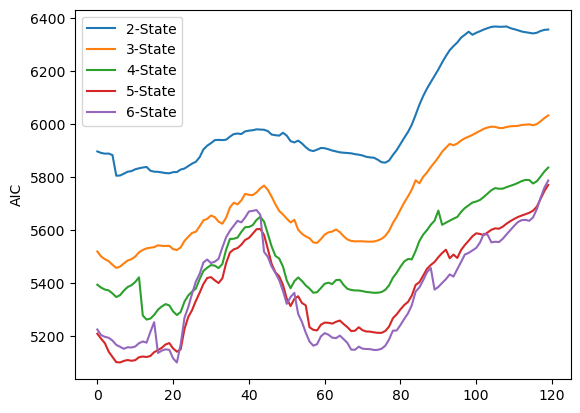

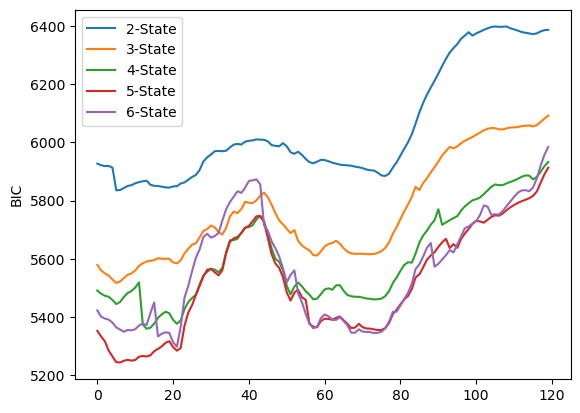

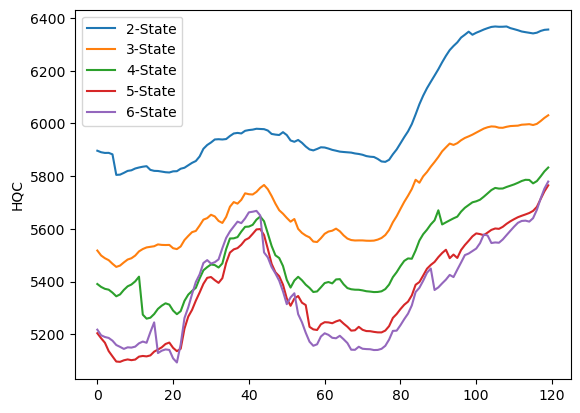

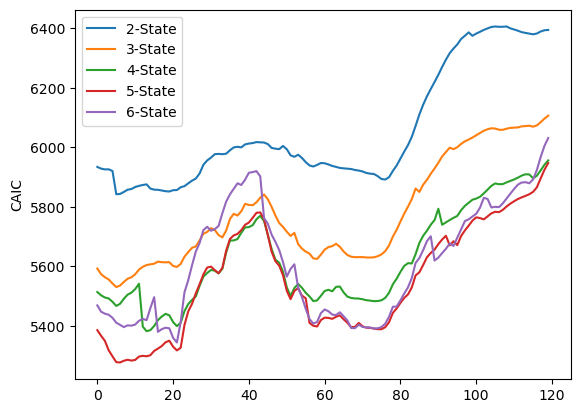

In [5]:
# Plot AIC values for different numbers of components
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.ylabel("AIC")

plt.legend()
plt.show()

# Plot BIC values for different numbers of components
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.ylabel("BIC")
plt.legend()
plt.show()

# Plot HQC values for different numbers of components
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.ylabel("HQC")
plt.legend()
plt.show()

# Plot CAIC values for different numbers of components
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.ylabel("CAIC")
plt.legend()
plt.show()

In [6]:
sample

,Open,High,Low,Close
561,757.020020,761.750000,716.690002,740.739990
562,740.739990,794.669983,729.549988,786.159973
563,786.159973,817.679993,773.429993,790.820007
564,790.820007,814.900024,756.130005,757.119995
565,757.119995,804.130005,733.539978,801.340027
...,...,...,...,...
796,2099.340088,2177.090088,2074.020020,2173.600098
797,2173.149902,2193.810059,2147.580078,2170.949951
798,2171.330078,2187.870117,2119.120117,2168.270020
799,2164.330078,2169.600098,2114.719971,2126.149902


In [7]:
full

,Open,High,Low,Close
0,17.240000,17.559999,17.070000,17.290001
1,17.530001,18.049999,17.530001,17.959999
2,18.219999,18.780001,18.110001,18.780001
3,18.770000,19.400000,17.440001,17.690001
4,17.639999,17.910000,16.680000,17.840000
...,...,...,...,...
796,2099.340088,2177.090088,2074.020020,2173.600098
797,2173.149902,2193.810059,2147.580078,2170.949951
798,2171.330078,2187.870117,2119.120117,2168.270020
799,2164.330078,2169.600098,2114.719971,2126.149902


T=  240
HMM Prices: 
[89.62999725341797, 81.5199966430664, 76.55000305175781, 84.66000366210938, 77.20000457763672, 74.58000946044922, 76.18999481201172, 80.47000122070312, 87.19999694824219, 92.1500015258789, 95.87999725341797, 96.75, 100.30999755859375, 103.94999694824219, 108.2699966430664, 100.55999755859375, 95.58000183105469, 91.26000213623047, 99.72000122070312, 94.2300033569336, 90.12001037597656, 102.08999633789062, 110.18999481201172, 106.56999969482422, 107.19999694824219, 107.66999816894531, 109.52999877929688, 107.13999938964844, 107.38999938964844, 111.08999633789062, 114.78999328613281, 114.25, 111.04000854492188, 118.05000305175781, 116.02999877929688, 111.68000030517578, 111.5199966430664, 106.97000122070312, 104.94999694824219, 104.26000213623047, 102.23999786376953, 107.5300064086914, 108.43000030517578, 108.29000091552734, 108.1500015258789, 97.55000305175781, 96.56999969482422, 96.22000122070312, 93.9800033569336, 90.30999755859375, 87.27999877929688, 86.0, 79.3099

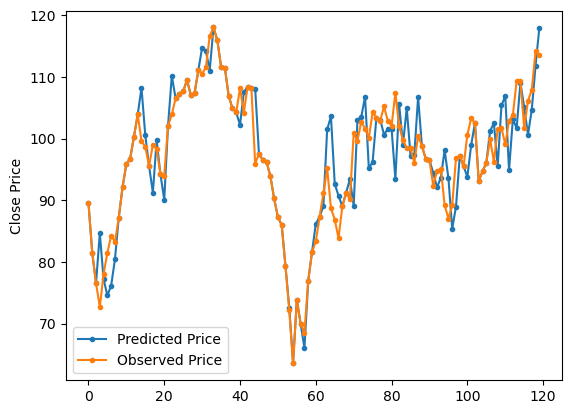

In [8]:
# Calculate number of rows and set training window
T = sample.shape[0]
print("T= ", T)

# Define the size of the training window
d = 120
D = 120
hmm_price = []

temp_T = T
first_time = True

# Sliding window approach to predict future prices
while T < temp_T + d:

    # Train HMM on data from T-D+1 to T
    train_data = full.iloc[T-D:T]
    train_data = train_data.dropna()

    # Set the random seed
    np.random.seed(123)

    if(first_time):
      first_time = False
      model = hmm.GaussianHMM(n_components=5)
    else:
      old_model= model
      model = hmm.GaussianHMM(n_components=5, init_params="c")
      model.startprob_ = old_model.startprob_
      model.transmat_ = old_model.transmat_
      model.means_ = old_model.means_

    model.fit(train_data)

    # Calculate original likelihood
    original_likelihood = model.score(train_data)

    # Loop to find new likelihood
    t=T
    min_diff = float('inf')
    min_t = T
    min_likelihood = original_likelihood
    while t-D>  0:
        t = t-1

        train_data = full.iloc[t-D:t]
        new_likelihood = model.score(train_data)
        if (abs(new_likelihood - original_likelihood))< min_diff:  # Threshold for comparison by choosing that new_likelihood which is minimum
            min_diff = abs(new_likelihood - original_likelihood)
            min_t = t
            min_likelihood = new_likelihood

    # Calculate the predicted close price
    close_price = full['Close'][T-1] + ((full['Close'][min_t + 1] - full['Close'][min_t]) * np.sign(original_likelihood - min_likelihood))

    hmm_price.append(close_price)
    T=T+1

# Print the calculated prices
print("HMM Prices: ")
print(hmm_price)

# Plot the predicted and observed prices
close = []
truncated_obs = full.iloc[T-d:T]

for i in truncated_obs['Close']:
  close.append(i)

plt.plot(hmm_price,marker='.', label = "Predicted Price")
plt.plot(close,marker = '.', label= "Observed Price")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [9]:
full.dropna()

,Open,High,Low,Close
0,17.240000,17.559999,17.070000,17.290001
1,17.530001,18.049999,17.530001,17.959999
2,18.219999,18.780001,18.110001,18.780001
3,18.770000,19.400000,17.440001,17.690001
4,17.639999,17.910000,16.680000,17.840000
...,...,...,...,...
796,2099.340088,2177.090088,2074.020020,2173.600098
797,2173.149902,2193.810059,2147.580078,2170.949951
798,2171.330078,2187.870117,2119.120117,2168.270020
799,2164.330078,2169.600098,2114.719971,2126.149902
